<a href="https://colab.research.google.com/github/Antony-Berlin/eye-disease-classification/blob/main/ViT_fine_tuning_with_Bean_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# blocks output in Colab 💄
%%capture

! pip install datasets transformers
!pip install accelerate -U
!pip install transformers

## Load a dataset

In [ ]:
from datasets import load_dataset

ds = load_dataset('beans')
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

In [ ]:
ex = ds['train'][400]
ex

{'image_file_path': '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/bean_rust/bean_rust_train.148.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 1}

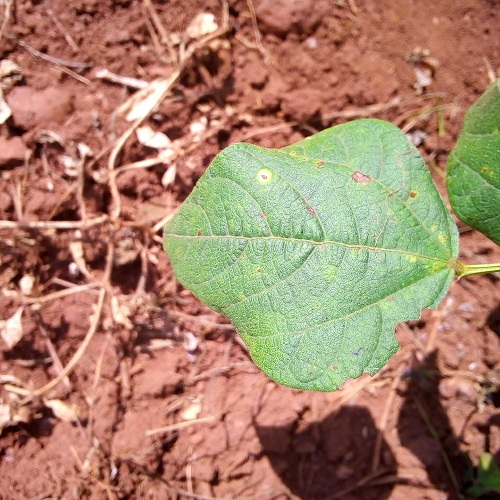

In [ ]:
image = ex['image']
image

In [ ]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [ ]:
labels.int2str(ex['labels'])

'bean_rust'

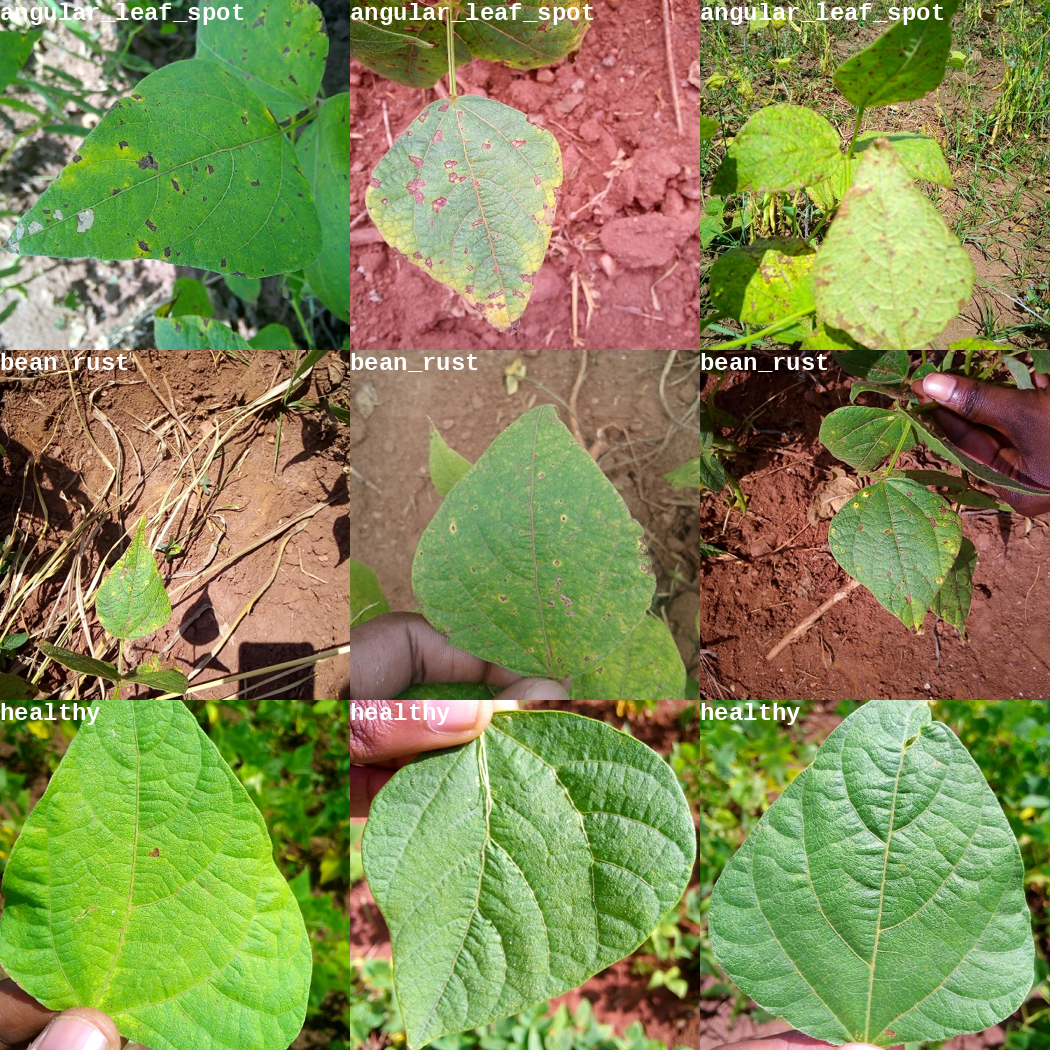

In [ ]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

## Loading ViT Feature Extractor



In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[ 0.7882,  0.6706,  0.7098,  ..., -0.1922, -0.1294, -0.1765],
          [ 0.7098,  0.6000,  0.6784,  ..., -0.2863, -0.1608, -0.1608],
          [ 0.4902,  0.3882,  0.4667,  ..., -0.1922, -0.0196,  0.0275],
          ...,
          [ 0.3804,  0.5294,  0.4824,  ..., -0.8275, -0.8196, -0.8039],
          [ 0.0902,  0.3725,  0.3804,  ..., -0.8667, -0.8431, -0.8510],
          [-0.0510,  0.2784,  0.3176,  ..., -0.8588, -0.8275, -0.8353]],

         [[ 0.4902,  0.3490,  0.3804,  ..., -0.6078, -0.5373, -0.5843],
          [ 0.3569,  0.2000,  0.3176,  ..., -0.7255, -0.6000, -0.5922],
          [ 0.0431, -0.0902,  0.0588,  ..., -0.6392, -0.4745, -0.4275],
          ...,
          [-0.2235, -0.0510, -0.0902,  ..., -0.9686, -0.9529, -0.9294],
          [-0.5059, -0.2078, -0.1922,  ..., -0.9922, -0.9922, -1.0000],
          [-0.6471, -0.2941, -0.2471,  ..., -0.9843, -0.9765, -0.9843]],

         [[ 0.4196,  0.2706,  0.3020,  ..., -0.7098, -0.6392, -0.6863],
          [ 0

## Processing the Dataset

In [ ]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [ ]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1843, -0.2471],
          [-0.6078, -0.6000, -0.5765,  ..., -0.0353, -0.0196, -0.2627],
          [-0.6314, -0.6314, -0.6078,  ..., -0.2314, -0.3647, -0.2235],
          ...,
          [-0.5373, -0.5529, -0.5843,  ..., -0.0824, -0.0431, -0.0902],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3098,  0.1843,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2627,  0.1608,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3647, -0.3255, -0.5686],
          [-0.7490, -0.7490, -0.7725,  ..., -0.5373, -0.6549, -0.5373],
          ...,
          [-0.7725, -0.7804, -0.8196,  ..., -0.2235, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1922,  0.3098,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0824,  0.2784,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3569, -0.7255],
          [-0

In [ ]:
ds = load_dataset('beans')

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

In [ ]:
prepared_ds = ds.with_transform(transform)

In [ ]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1843, -0.2471],
          [-0.6078, -0.6000, -0.5765,  ..., -0.0353, -0.0196, -0.2627],
          [-0.6314, -0.6314, -0.6078,  ..., -0.2314, -0.3647, -0.2235],
          ...,
          [-0.5373, -0.5529, -0.5843,  ..., -0.0824, -0.0431, -0.0902],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3098,  0.1843,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2627,  0.1608,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3647, -0.3255, -0.5686],
          [-0.7490, -0.7490, -0.7725,  ..., -0.5373, -0.6549, -0.5373],
          ...,
          [-0.7725, -0.7804, -0.8196,  ..., -0.2235, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1922,  0.3098,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0824,  0.2784,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3569, -0.7255],
          [-0

# Training and Evaluation



In [ ]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-17-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo-v5",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1355
  train_runtime            =  0:01:46.54
  train_samples_per_second =       38.82
  train_steps_per_second   =        2.44


In [ ]:
trainer.save_model("/content/drive/MyDrive/FINAL_YR_PRJ/Bean Leaf clsfktn VIT/run1")

In [ ]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =      0.985
  eval_loss               =     0.0772
  eval_runtime            = 0:00:01.91
  eval_samples_per_second =     69.319
  eval_steps_per_second   =       8.86


In [ ]:
# Inference

In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

0


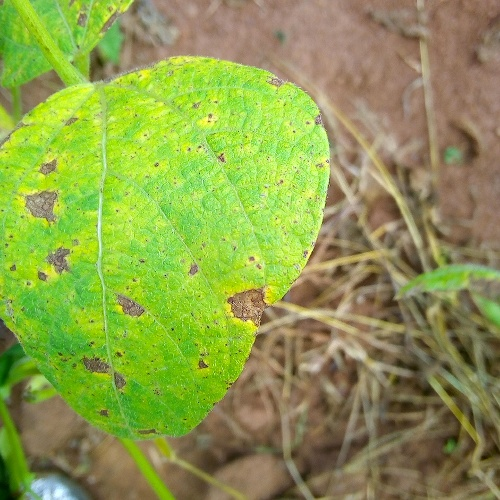

In [ ]:
# url = 'https://plantwiseplusknowledgebank.org/cms/asset/b275330f-564f-48be-82ad-ba617d97ae6c/d7642e7a-f7b3-4cdd-93b4-1765f42cc33c.jpg'
# image = Image.open(requests.get(url, stream=True).raw)

ex = ds['test'][14]
image =ex['image']
print(ex['labels'])
image

In [ ]:
processor = ViTImageProcessor.from_pretrained('/content/drive/MyDrive/FINAL_YR_PRJ/Bean Leaf clsfktn VIT/run1')
model = ViTForImageClassification.from_pretrained('/content/drive/MyDrive/FINAL_YR_PRJ/Bean Leaf clsfktn VIT/run1')

In [ ]:
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

In [ ]:
print(logits)

tensor([[ 3.5320, -1.6028, -1.6235]], grad_fn=<AddmmBackward0>)


In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print(predicted_class_idx)
print("Predicted class:", model.config.id2label[predicted_class_idx])

0
Predicted class: angular_leaf_spot
